# Question 5

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
root = './A2_resources/'

In [3]:
def read(path, arg = cv2.IMREAD_UNCHANGED):
    args = {'gray' : cv2.IMREAD_GRAYSCALE, 'unchanged' : cv2.IMREAD_UNCHANGED, 'color' : cv2.IMREAD_COLOR}
    return cv2.imread(path, args[arg])

In [4]:
def strided(img, kernel):
    img = img.astype('int32')
    img = np.pad(img, (np.int32((kernel.shape[0]-1)/2), np.int16((kernel.shape[1]-1)/2)), 'reflect')
    expanded_input = np.lib.stride_tricks.as_strided(
    img,
    shape=(
        img.shape[0] - kernel.shape[0] + 1,
        img.shape[1] - kernel.shape[1] + 1,
        kernel.shape[0],
        kernel.shape[1],
    ),
    strides=(
        img.strides[0],
        img.strides[1],
        img.strides[0],
        img.strides[1],
    )
)
    return expanded_input

In [5]:
def conv2d(img, kernel):

    channels = 1
    if len(img.shape) > 2:
        channels = img.shape[2]

    if channels == 1:
        return np.tensordot(strided(img, kernel), kernel)
    else:
        res = np.tensordot(strided(img[:,:,0], kernel), kernel)
        for i in range(1,channels):
            res = np.dstack((res, np.tensordot(strided(img[:,:,i], kernel), kernel)))
        return res

### Naive mean filter
- The naive implementation of mean filter does convolution with $ones(k)/(k^2)$ with each kxk window in the image

In [6]:
def meanFilter(img, k):
    img = img.astype('int32')
    kernel = np.ones((k, k))/(k*k)
    return np.uint8(conv2d(img, kernel))

### Optimised mean filter
- In the optimised approach dynamic programming is used.
- Cumulative sum is taken along both axes, so the dp array stores the sum of the submatrices as dp[i][j] contains the sum of matrix from (0,0) to (i,j). Hence for calcuating the sum of window (i1,j1) and (i2,j2) can be done in O(1) time, as sum of submatrix(i1,j1,i2,j2) = dp[i2][j2] - dp[i2][j1] - dp[i1][j2] + dp[i1][j1]. (it is more efficient than running mean approach)

In [7]:
def meanOptimized(img, k):
    img = img.astype('int32')
    kernel = np.ones((k, k))/(k*k)
    cmsm = np.cumsum(img, axis = 1)
    cmsm = np.cumsum(cmsm, axis = 0)
    
    rcmsm = np.roll(cmsm, (k) , axis = 0)
    rcmsm[0:k,:] = 0
    ccmsm = np.roll(cmsm, (k) , axis = 1)
    ccmsm[:,0:k] = 0
    bcmsm = np.roll(cmsm, (k), axis = (0,1))
    bcmsm[:,0:k] = 0
    bcmsm[0:k,:] = 0
    out = cmsm - rcmsm - ccmsm + bcmsm    

    return np.uint8(out/(k*k))

### Naive median filter
- The naive median filter approach takes median of each kxk size window.

In [8]:
def medianFilter(img, k):
    img = img.astype('int32')
    out = np.zeros(img.shape)
    for i in range(img.shape[0]-k):
        for j in range(img.shape[1]-k):
            out[i][j] = np.median(img[i:i+k-1,j:j+k-1])
    return np.uint8(out)

In [9]:
def medianStrided(img, k):
    img = img.astype('int32')
    kernel = np.ones((k, k))/(k*k)
    expanded = np.median(strided(img, kernel), axis = (2,3))
    return np.uint8(expanded)

### Optimised median filter
- In the optimized approach(running median by histogram), we store the histogram of kernel. When the kernel is shifted along the columns, the new column histogram is added and the previous column histogram is removed. (Histogram of the columns upto k rows is considered initially). The histogram of columns is updated after each new row (this can be vectorized)

In [10]:
def medianOptimized(img, k):
    x = np.apply_along_axis(lambda a : np.histogram(a, bins = np.arange(257))[0], 0, img[0:k,:])

    out = np.zeros((img.shape))
    ind = np.arange(img.shape[1])
    
    for i in range(k-1, img.shape[0]): 
        kernel = np.sum(x[:,0:k],axis = 1).T
        kernel = kernel[np.newaxis, :]
        for j in range(k-1,img.shape[1]):

            cmsm = np.cumsum(kernel, axis  = 1)
            temp = np.where(cmsm>=(k*k/2))[1]
            out[i][j] = temp[0]
            if j == img.shape[1]-1:
                break
            kernel += (x[:,j+1]-x[:,j-k+1]).T
        if i == img.shape[0]-1:
            break
        x[img[i-k+1,:], ind] -= 1
        x[img[i+1,:], ind] += 1

    return np.uint8(out)
    

In [11]:
def applyFilter(imfilter, img, k):
    if len(img.shape) == 2:
        return imfilter(img,k)
    else:
        return np.dstack((imfilter(img[:,:,0],k),imfilter(img[:,:,1],k),imfilter(img[:,:,2],k)))

## Part 1 and Part 2

## Comparison run time mean filters

0 1 2 3 4 

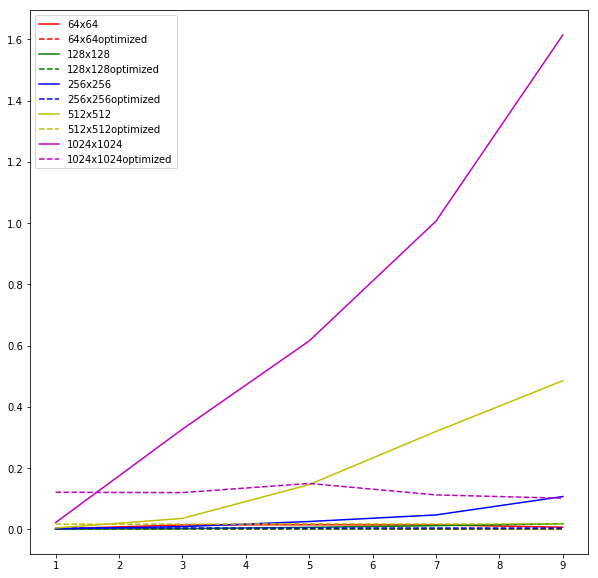

In [12]:
im = read(root+'barbara.jpg', 'color')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (10,10))
sizes = [64, 128, 256, 512, 1024]
ks = [1, 3, 5, 7, 9]
colors = ['r', 'g', 'b', 'y', 'm']

for sz in range(len(sizes)):
    tm1 = []
    tm2 = []
    for k in ks:
        start = time.time()
        out = applyFilter(meanFilter, im[0:sizes[sz],0:sizes[sz],:], k)
        end = time.time()
        tm1.append((end - start)*1)
        start = time.time()
        out = applyFilter(meanOptimized, im[0:sizes[sz],0:sizes[sz],:], k)
        end = time.time()
        tm2.append((end - start)*1)
    print(sz, end = ' ')
    plt.plot(ks, tm1, color = colors[sz], label = str(sizes[sz])+'x'+str(sizes[sz]))
    plt.plot(ks, tm2, color = colors[sz], linestyle = 'dashed', label = str(sizes[sz])+'x'+str(sizes[sz]) + 'optimized')

plt.legend()
plt.show()


## Part 3

## Comparison run time median filters

0 1 2 3 4 

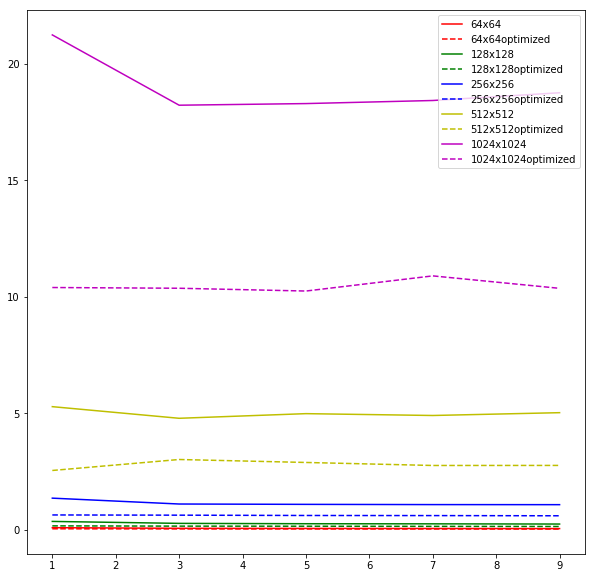

In [13]:
im = read(root+'barbara.jpg', 'color')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (10,10))
sizes = [64, 128, 256, 512, 1024]
ks = [1, 3, 5, 7, 9]
colors = ['r', 'g', 'b', 'y', 'm']

for sz in range(len(sizes)):
    tm1 = []
    tm2 = []
    for k in ks:
        start = time.time()
        out = applyFilter(medianFilter, im[0:sizes[sz],0:sizes[sz],0], k)
        end = time.time()
        tm1.append((end - start)*1)
        start = time.time()
        out = applyFilter(medianOptimized, im[0:sizes[sz],0:sizes[sz],0], k)
        end = time.time()
        tm2.append((end - start)*1)
    print(sz , end = ' ')
    plt.plot(ks, tm1, color = colors[sz], label = str(sizes[sz])+'x'+str(sizes[sz]))
    plt.plot(ks, tm2, color = colors[sz], linestyle = 'dashed', label = str(sizes[sz])+'x'+str(sizes[sz]) + 'optimized')

plt.legend()
plt.show()


##  Results with mean and median filters

In [14]:
im = read(root+'cameraman.png','color')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

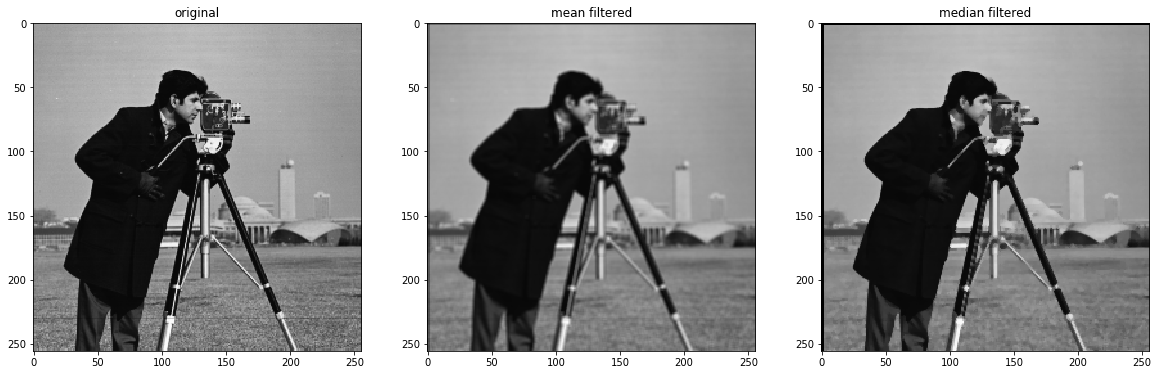

In [15]:
_,plots = plt.subplots(1,3,figsize = (20,20))
plots[0].imshow(im)
plots[0].set_title('original')
plots[1].imshow(applyFilter(meanOptimized, im, 3))
plots[1].set_title('mean filtered')
plots[2].imshow(applyFilter(medianOptimized, im, 3))
plots[2].set_title('median filtered')

plt.show()